In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.regularizers import l2
import os
import numpy as np
import xml.etree.ElementTree as ET
from tensorflow.keras.optimizers import RMSprop

#gpu로학습
os.environ["CUDA_VISIBLE_DEVICES"]="0"
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    # 라벨데이터 추가, 없을시 생략
    def read_xml_file(xml_file_path):
        if not os.path.isfile(xml_file_path):
            return []
        tree = ET.parse(xml_file_path)
        root = tree.getroot()
        labels = []
        for obj in root.findall('object'):
            label = obj.find('name').text
            labels.append(label)
        return labels

    def read_xml_and_add_labels(image_path, label_directory):
        if not os.path.isfile(image_path):
            return []
        image_name = os.path.basename(image_path)
        class_name = os.path.dirname(image_path).split(os.path.sep)[-1]
        xml_file_path = os.path.join(label_directory, class_name, image_name[:-4] + '.xml')
        labels = read_xml_file(xml_file_path)
        return labels


    # 데이터증강기법
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        preprocessing_function=lambda img: tf.image.random_crop(img, [256, 256, 3])
    )

    # 훈련 데이터셋
    train_directory = 'E:/종설/Training/ex'
    train_label_directory = 'E:/종설/Training/label_ex'
    train_dataset = train_datagen.flow_from_directory(
        train_directory,
        target_size=(256, 256),
        batch_size=300,
        shuffle=True,
        seed=42,  # add a seed for reproducibility
        follow_links=True,  # follow symbolic links if any
        classes=None,  # set to None to use default class mode
    )

    # 훈련라벨
    train_labels = []
    for i, image_path in enumerate(train_dataset.filepaths):
        labels = read_xml_and_add_labels(image_path, train_label_directory)
        train_labels.append(labels)


    train_labels = np.array(train_labels)

    # 검증 데이터셋
    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        preprocessing_function=lambda img: tf.image.random_crop(img, [256, 256, 3])
    )

    # 검증데이터
    val_directory = 'E:/종설/Validation/ex'
    val_label_directory = 'E:/종설/Validation/label_ex'
    val_dataset = val_datagen.flow_from_directory(
        val_directory,
        target_size=(256, 256),
        batch_size=300,
        shuffle=True,
        seed=42,  # add a seed for reproducibility
        follow_links=True,  # follow symbolic links if any
        classes=None,  # set to None to use default class mode
    )

    # 검증라벨
    val_labels = []
    for i, image_path in enumerate(val_dataset.filepaths):
        labels = read_xml_and_add_labels(image_path, val_label_directory)
        val_labels.append(labels)

    val_labels = np.array(val_labels)

    # EfficientNet-B0모델 불러오기
    pretrained_model = hub.KerasLayer("C:/Users/sj990/MachineLearning/efficientnet_b0_feature-vector_1")

    # 층 추가
    model = Sequential()
    model.add(pretrained_model)
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(train_dataset.num_classes, activation='softmax', kernel_regularizer=l2(0.0005)))

    # 동결
    for layer in model.layers[:-1]:
        layer.trainable = False

    # 컴파일 - 학습률조정
    model.compile(
        optimizer=RMSprop(lr=0.001),  # Use RMSprop as the optimizer
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    num_epochs = 10
    best_val_acc = 0.0


    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=val_dataset,
    )

    # 모델저장
    best_val_acc = max(history.history['val_accuracy'])
    model.save('model_prototype_v1.h5')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Found 219333 images belonging to 1924 classes.


C:\Users\sj990\AppData\Local\Temp\ipykernel_7776\3036733940.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_labels = np.array(train_labels)


Found 28860 images belonging to 1924 classes.


In [8]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14958323829355149910,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10081009664
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16443926071426643424
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"]

In [23]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_9 (KerasLayer)   (None, 1000)              5330564   
_________________________________________________________________
dropout_17 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               512512    
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 10)                5130      
Total params: 5,848,206
Trainable params: 5,130
Non-trainable params: 5,843,076
_________________________________________________________________


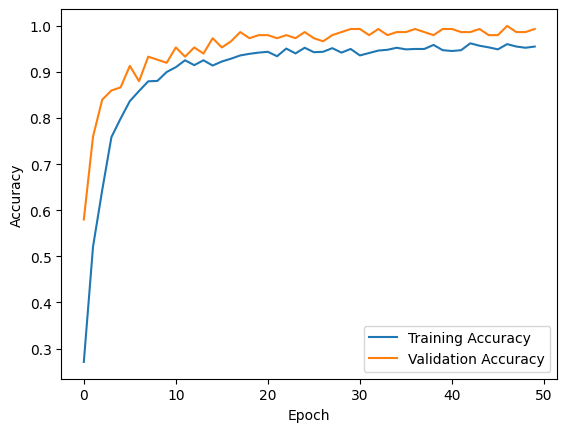

In [4]:
import matplotlib.pyplot as plt

# Get the accuracy values from history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the accuracy values
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

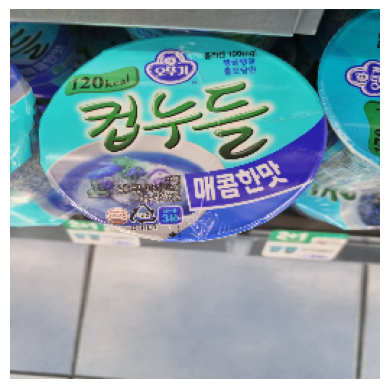

결과순위 1: 10111_오뚜기컵누들매콤37.8G (0.93)
결과순위 2: 10103_오뚜기참깨라면(컵) (0.06)
결과순위 3: 10104_오뚜기)컵누들김치쌀국수34.8G (0.01)


In [5]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the model
model = tf.keras.models.load_model('my_model_ex_label_v51.h5', custom_objects={'KerasLayer':hub.KerasLayer})


# Load test image and preprocess
img_path = r'C:\Users\sj990\Desktop\ex\KakaoTalk_20230421_152615727.jpg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
img = tf.keras.preprocessing.image.img_to_array(img)
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)

plt.imshow(cv2.cvtColor(img[0], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


# Predict the label of the image
preds = model.predict(img)
class_indices = train_dataset.class_indices
class_labels = list(class_indices.keys())

# Get the top three predicted labels and probabilities
top_preds_idx = preds[0].argsort()[::-1][:3]
top_preds_labels = [class_labels[idx] for idx in top_preds_idx]
top_preds_probs = preds[0][top_preds_idx]

i=1;
# Print out the top three predicted labels and probabilities
for label, prob in zip(top_preds_labels, top_preds_probs):
    print(f"결과순위 {i}: {label} ({prob:.2f})")
    i=i+1

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.regularizers import l2
import os
import numpy as np
import xml.etree.ElementTree as ET

# Load the model
model = tf.keras.models.load_model('my_model_ex_label_v51.h5', custom_objects={'KerasLayer':hub.KerasLayer})

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) # you can specify other data augmentation techniques or preprocessing steps here
test_generator = test_datagen.flow_from_directory(
        r'C:\Users\sj990\Desktop\ex', 
        target_size=(256, 256), 
        batch_size=1, 
        class_mode='categorical', 
        shuffle=False) 

scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1] * 100)) 

Found 61 images belonging to 10 classes.


C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\keras\backend.py:4846: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


61/61 [==============================] - 2s 15ms/step - loss: 0.4136 - accuracy: 0.9180
Accuracy: 91.80%
